In [48]:
# pip install subword-nmt seaborn lifelines openpyxl matplotlib scikit-learn openTSNE
# pip install torchmetrics==1.2.0 pandas==2.1.4 numpy==1.26.4
# python3 ./main_kfold.py --config utils/config.py
import torch.nn as nn
from utils.Loss import Custom_LossFunction,Custom_Weighted_LossFunction,FocalLoss
from utils.Custom_Activation_Function import ScaledSigmoid, ReLU_clamp
from utils.Metrics import MetricsCalculator_nntorch

model_inference = True # False
if model_inference is True:
    cohort = "TCGA"
    geneNUM = "" # _4692genes tcgadata tcgalabel tcgadata_4692genes tcgalabel_4692genes

    


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  DataLoader, Subset
import torch.nn.init as init
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import gc
import os
import importlib.util
import pickle
import torchmetrics
from scipy.stats import ttest_ind
import time

from utils.ESPF_drug2emb import drug2emb_encoder
# from utils.Model import Omics_DrugESPF_Model, Omics_DCSA_Model, GIN_DCSA_model
from utils.split_data_id import split_id,repeat_func
from utils.create_dataloader import OmicsDrugDataset,InstanceResponseDataset
# from utils.train import train, evaluation
from utils.correlation import correlation_func
from utils.plot import loss_curve, correlation_density, Density_Plot_of_AUC_Values, Confusion_Matrix_plot, TCGA_predAUDRC_box_plot_twoClass
from utils.tools import get_data_value_range,set_seed,get_vram_usage
print("*"*100)


drug_encode_dims None
dense_layer_dim [7064, 700, 70, 1]
****************************************************************************************************


In [2]:
# best_weight_path = './inference/BF3_test_loss0.0565073_BestValEpo15_ModelOmics_DCSA_Model_byCCL_OmicsMut_Exp_ESPFTrue_DrugSelfAttentionTrue/'
best_weight_path = './results/2025-0708-0400_BF0_weighted_BCE_test_loss0.6038948_BestValEpo3_Omics_DCSA_Model_ModelID_ESPFTrue_DrugSelfAttenTrue_Exp1426_nlayer1_DA-None/'
best_prob_threshold = 0.4682268500328064
BF=0

In [49]:
# information
struct_time   = time.localtime()
timestamp    = time.strftime("%Y-%m%d-%H%M", struct_time)
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")
# 檢查exp和AUC的samples是否一致
if DA_Folder != 'None':
    with open(omics_files['Exp'], 'rb') as f:
        latent_dict = pickle.load(f)
        exp_df = pd.DataFrame(latent_dict).T
else:
    exp_df = pd.read_csv(omics_files["Exp"], sep=',', index_col=0)
exp_df = exp_df.sort_index(axis=0).sort_index(axis=1)
AUC_df_numerical = pd.read_csv(AUC_df_path_numerical, sep=',', index_col=0)
AUC_df_numerical = AUC_df_numerical.sort_values(by='drug_name').sort_values(by='ModelID')
print(f"exp_df samples: {len(exp_df.index)} , AUC_df_numerical samples: {len(AUC_df_numerical.index)}")
matched_samples = sorted(set(AUC_df_numerical['ModelID']) & set(exp_df.index))
print("len(matched_samples)",len(matched_samples))
# 讀取omics資料
set_seed(seed)
scaler_dict = {}  # To store scalers for each omic_type
for omic_type in include_omics:
    if DA_Folder != 'None':
        omics_data_dict[omic_type] = exp_df.loc[matched_samples]
    else:
        omics_data_dict[omic_type] = pd.read_csv(omics_files[omic_type], sep=',', index_col=0).loc[matched_samples]
        omics_data_dict[omic_type] = omics_data_dict[omic_type].sort_index(axis=0).sort_index(axis=1)
        if omic_type == "Exp":# apply Column-wise Standardization 
            scaler = StandardScaler() 
            omics_data_dict[omic_type] = pd.DataFrame(scaler.fit_transform(omics_data_dict[omic_type]),index=omics_data_dict[omic_type].index,columns=omics_data_dict[omic_type].columns)
            scaler_dict[omic_type] = scaler  # save the fitted scaler for latter inference
        
    # omics_data_tensor_dict[omic_type]  = torch.tensor(omics_data_dict[omic_type].values, dtype=torch.float32).to(device)
    omics_numfeatures_dict[omic_type] = omics_data_dict[omic_type].shape[1]
    # print(f"{omic_type} tensor shape:", omics_data_tensor_dict[omic_type].shape)
    print(f"{omic_type} num_features",omics_numfeatures_dict[omic_type])
drug_df = pd.read_csv( drug_df_path, sep=',', index_col=0)
print("drug_df",drug_df.shape)
drug_df = drug_df.sort_index(axis=0).sort_index(axis=1)
if "BRD_ID" in drug_df.columns:
    drug_df["BRD_ID"] = drug_df["BRD_ID"].replace({"BRD-K61250484-001-02-3": "BRD-6125",
                                                    "BRD-K91701654-001-03-1 (CID5354033)": "BRD-K91701654-001-03-1",
                                                    "BRD-K18787491-001-08-6 (CID3006531)": "BRD-K18787491-001-08-6"})
print("drug_df",drug_df.shape)
print("AUC_df_numerical",AUC_df_numerical.shape)
# matched AUCfile and omics_data samples
AUC_df_numerical = AUC_df_numerical[AUC_df_numerical['ModelID'].isin(matched_samples)]
print("AUC_df_numerical match samples",AUC_df_numerical.shape)
# median_value = np.nanmedian(AUC_df_numerical.values)  # Directly calculate median, ignoring NaNs
# print("median_value",median_value)    
if 'BCE' in criterion.loss_type :
    AUC_df = AUC_df_numerical.copy()
    print("AUC_df",AUC_df.shape)
    if "BRD_ID" in drug_df.columns:
        drug_df = drug_df[drug_df["BRD_ID"].isin(AUC_df.columns.str.extract(r"(BRD-[^\)]+)", expand=False))]
    print("drug_df",drug_df.shape)
else:
    AUC_df = AUC_df_numerical.copy()
del AUC_df_numerical
if test is True:
    drug_df=drug_df[:10]
    AUC_df = AUC_df[AUC_df['drug_name'].isin(drug_df.index)]
    print("drug_df",drug_df.shape)
    print("AUC_df",AUC_df.shape)
if 'weighted' in criterion.loss_type :    
    if 'BCE' in criterion.loss_type :
        weighted_threshold = None
        total_samples = (~np.isnan(AUC_df["Label"])).sum().item()
        fewWt_samples = (AUC_df["Label"] == 0).sum().item()
        moreWt_samples = (AUC_df["Label"] == 1).sum().item()
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)
    else:
        # Set threshold based on the 90th percentile # 將高於threshold的AUC權重增加
        weighted_threshold = np.nanpercentile(AUC_df[response], 90)    
        total_samples = (~np.isnan(AUC_df[response])).sum().item()
        fewWt_samples = (AUC_df[response] > weighted_threshold).sum().item()
        moreWt_samples = total_samples - fewWt_samples
        few_weight = total_samples / (2 * fewWt_samples)  
        more_weight = total_samples / (2 * moreWt_samples)  
else:
    weighted_threshold = None
    few_weight = None
    more_weight = None
# convert SMILES to subword token by ESPF
if ESPF is True:
    # 挑出重複的SMILES
    duplicate =  drug_df["SMILES"][drug_df["SMILES"].duplicated(keep=False)]
    vocab_path = "./ESPF/drug_codes_chembl_freq_1500.txt" # token
    sub_csv = pd.read_csv("./ESPF/subword_units_map_chembl_freq_1500.csv")# token with frequency
    drug_df["drug_encode"] = pd.Series(drug_df["SMILES"]).apply(drug2emb_encoder, args=(vocab_path, sub_csv, max_drug_len))
    print("drug_encode",type(drug_df["drug_encode"]))
    drug_df["drug_encode"] = [i[:2] for i in drug_df["drug_encode"].values]
    # drug_features_tensor = torch.tensor(np.array([i[:2] for i in drug_encode.values]), dtype=torch.long).to(device)#drug_features_tensor = torch.tensor(np.array(drug_encode.values.tolist()), dtype=torch.long).to(device)
else:
    drug_df["drug_encode"]=[list(map(int, item.split(','))) for item in drug_df["MACCS166bits"].values]
    # drug_features_tensor = torch.tensor(np.array(drug_encode_list), dtype=torch.long).to(device)
#--------------------------------------------------------------------------------------------------------------------------
num_ccl = list(omics_data_dict.values())[0].shape[0]
num_drug = drug_df["drug_encode"].shape[0]
print("num_ccl,num_drug: ",num_ccl,num_drug)


Training on device cuda.
exp_df samples: 1305 , AUC_df_numerical samples: 106308
len(matched_samples) 588
Exp num_features 1426
drug_df (214, 2)
drug_df (214, 2)
AUC_df_numerical (106308, 13)
AUC_df_numerical match samples (106308, 13)
AUC_df (106308, 13)
drug_df (214, 2)
drug_encode <class 'pandas.core.series.Series'>
num_ccl,num_drug:  588 214


In [52]:
AUC_df

array(['ovary', 'large_intestine', 'melanoma',
       'lung_NSCLC_adenocarcinoma', 'lung_NSCLC_large cell', 'Bladder',
       'breast', 'pancreas', 'glioma', 'kidney', 'rhabdomyosarcoma',
       'fibrosarcoma', 'medulloblastoma', 'thyroid', 'ewings_sarcoma',
       'mesothelioma', 'lung_small_cell_carcinoma', 'stomach',
       'lung_NSCLC_squamous_cell_carcinoma', 'head and neck',
       'endometrium', 'liver', 'oesophagus', 'osteosarcoma',
       'soft_tissue_other', 'lung_NSCLC_not specified', 'uterus',
       'chondrosarcoma', 'digestive_system_other', 'bone_other',
       'lung_NSCLC_carcinoid', 'skin_other', 'cervix',
       'urogenital_system_other'], dtype=object)

In [5]:
cancerType_mapping = {'ovary': 'Ovarian Cancer',
                        'acute_myeloid_leukaemia': 'na',
                        'large_intestine': 'Colon/Colorectal Cancer',
                        'melanoma': 'Skin Cancer',
                        'lung_NSCLC_adenocarcinoma': 'Lung Cancer',
                        'lung_NSCLC_large cell': 'Lung Cancer',
                        'Bladder': 'Bladder Cancer',
                        'breast': 'Breast Cancer',
                        'B_cell_leukemia': 'na',
                        'pancreas': 'Pancreatic Cancer',
                        'myeloma': 'na',
                        'glioma': 'Brain Cancer',
                        'leukemia': 'na',
                        'kidney': 'Kidney Cancer',
                        'rhabdomyosarcoma': 'Sarcoma',
                        'anaplastic_large_cell_lymphoma': 'na',
                        'fibrosarcoma': 'Sarcoma',
                        'medulloblastoma': 'Brain Cancer',
                        'B_cell_lymphoma': 'na',
                        'thyroid': 'Thyroid Cancer',
                        'lymphoblastic_leukemia': 'na',
                        'T_cell_leukemia': 'na',
                        'chronic_myeloid_leukaemia': 'na',
                        'neuroblastoma': 'na',
                        'ewings_sarcoma': 'Sarcoma',
                        'prostate': 'Prostate Cancer',
                        'mesothelioma': 'na',
                        'lymphoblastic_T_cell_leukaemia': 'na',
                        'lymphoid_neoplasm other': 'na',
                        'lung_small_cell_carcinoma': 'Lung Cancer',
                        'stomach': 'Gastric Cancer',
                        'Burkitt_lymphoma': 'na',
                        'lung_NSCLC_squamous_cell_carcinoma': 'Lung Cancer',
                        'head and neck': 'Head and Neck Cancer',
                        'endometrium': 'Endometrial/Uterine Cancer',
                        'haematopoietic_neoplasm other': 'na',
                        'liver': 'Liver Cancer',
                        'Hodgkin_lymphoma': 'na',
                        'oesophagus': 'Esophageal Cancer',
                        'osteosarcoma': 'Sarcoma',
                        'soft_tissue_other': 'Sarcoma',
                        'lung_NSCLC_not specified': 'Lung Cancer',
                        'uterus': 'Endometrial/Uterine Cancer',
                        'chondrosarcoma': 'Sarcoma',
                        'digestive_system_other': 'Colon/Colorectal Cancer',
                        'bone_other': 'Sarcoma',
                        'lung_NSCLC_carcinoid': 'Lung Cancer',
                        'skin_other': 'Skin Cancer',
                        'cervix': 'Cervical Cancer',
                        'urogenital_system_other': 'Prostate Cancer',
                        'adrenal_gland': 'na'}
# AUC_df['CancerType'] = AUC_df['GDSC_tissue'].map(cancerType_mapping)
# AUC_df = AUC_df[AUC_df['CancerType'] != 'na']
# AUC_df = AUC_df[AUC_df['CancerType'] != nan]
# AUC_df = AUC_df[AUC_df['CancerType'] != 'Prostate Cancer']

In [50]:
# AUC_df =  pd.read_csv("../../data/GDSC/TransCDR/CDR_bi_n107837_596ccl_214drug(ModelID)SMILES imbalanced.csv",sep=',',index_col=0)
ccle_sample_info_df= pd.read_csv("../data/DAPL/share/ccle_sample_info_df.csv", index_col=0, header=0)
AUC_df['primary_disease'] = AUC_df['ModelID'].map(ccle_sample_info_df['primary_disease'])
print(AUC_df['primary_disease'].unique())
cancerType_mapping = {'Leukemia': 'na',
                        'Myeloma': 'na',
                        'Bone Cancer': 'Sarcoma',
                        'Lymphoma': 'na',
                        'Neuroblastoma': 'na',
                        'Prostate Cancer': 'na',
                         'Rhabdoid': 'Sarcoma',
                         'Gallbladder Cancer': 'Bile Duct Cancer',
                         'Adrenal Cancer': 'na'}
AUC_df['primary_disease'] = AUC_df['primary_disease'].replace(cancerType_mapping)
print(AUC_df['primary_disease'].unique())
AUC_df = AUC_df[AUC_df['primary_disease'] != 'na'].copy()
print(len(AUC_df['ModelID'].unique()))
print(len(AUC_df['primary_disease'].unique()))

['Ovarian Cancer' 'Leukemia' 'Colon/Colorectal Cancer' 'Skin Cancer'
 'Lung Cancer' 'Bladder Cancer' 'Breast Cancer' 'Pancreatic Cancer'
 'Myeloma' 'Brain Cancer' 'Kidney Cancer' 'Bone Cancer' 'Lymphoma'
 'Sarcoma' 'Thyroid Cancer' 'Neuroblastoma' 'Prostate Cancer' 'Rhabdoid'
 'Gastric Cancer' 'Head and Neck Cancer' 'Endometrial/Uterine Cancer'
 'Liver Cancer' 'Esophageal Cancer' 'Cervical Cancer' 'Adrenal Cancer']
['Ovarian Cancer' 'na' 'Colon/Colorectal Cancer' 'Skin Cancer'
 'Lung Cancer' 'Bladder Cancer' 'Breast Cancer' 'Pancreatic Cancer'
 'Brain Cancer' 'Kidney Cancer' 'Sarcoma' 'Thyroid Cancer'
 'Gastric Cancer' 'Head and Neck Cancer' 'Endometrial/Uterine Cancer'
 'Liver Cancer' 'Esophageal Cancer' 'Cervical Cancer']
476
17


# Model

In [6]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import GINConv, global_add_pool, global_mean_pool,global_max_pool
import math
import copy
import numpy as np
# Modules------------------------------------------------------------------------------------------------------------------------------------------------------        
class SinusoidalPositionalEncoding(nn.Module):
  def __init__(self, hidden_size, max_len=50):
    super(SinusoidalPositionalEncoding, self).__init__()
    pe = torch.zeros(max_len, hidden_size) # torch.Size([50, 128])
    position = torch.arange(0, max_len).float().unsqueeze(1) # torch.Size([50, 1]) # 0~50
    div_term = torch.exp(torch.arange(0, hidden_size, 2).float() *
                         (-torch.log(torch.Tensor([10000])) / hidden_size)) # [max_len / 2]
                        #生成一個數位 [0， 2， 4， ...， hidden_size-2] 的張量（偶數索引）。
    pe[:, 0::2] = torch.sin(position * div_term) #將 sine 函數應用於位置編碼張量 （pe） 的偶數維數。
    pe[:, 1::2] = torch.cos(position * div_term) #將餘弦函數應用於位置編碼張量 （pe） 的奇數維數。
    pe = pe.unsqueeze(0) # torch.Size([1, 50, 128])
    # register pe to buffer and require no grads#緩衝區的參數在訓練期間不會更新
    self.register_buffer('pe', pe)
  def forward(self, x):
    # x: [batch, seq_len, hidden_size]
    # we can add positional encoding to x directly, and ignore other dimension
    return x + self.pe[:,:x.size(1)].to(x.device)# x.size(1)= 50
class LearnedPositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_len):#(128, 50)
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, hidden_size)#(128, 50) # 50個pos id(0~50)用128維vector來表示位置資訊
    def forward(self, x):# x: torch.Size([bsz, 50]) # 50個子結構id
            # seq_length = seq.size(1) #seq:(batchsize=64,50)# seq_length:50 # 50個onehot categorical id 𝜖(0~2585)
            # position_ids = torch.arange(seq_length, dtype=torch.long, device=seq.device) #position_ids:torch.Size([50]) (0~50)
            # position_ids = position_ids.unsqueeze(0).expand_as(seq)#position_ids:torch.Size([bsz, 50])
        seq_length = x.size(1) #x:(batchsize=64,50)# 50個onehot categorical id 𝜖(0~2585)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=x.device) #position_ids:torch.Size([50]) (0~50)
        position_ids = position_ids.unsqueeze(0).expand_as(x) #position_ids =>torch.Size([bsz, 50])
        return self.position_embeddings(position_ids)# generate torch.Size([bsz, 50, 128])位置特徵，每一個位置都用128為來描述
class LayerNorm(nn.Module):
    def __init__(self, hidden_size, variance_epsilon=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hidden_size))
        self.beta = nn.Parameter(torch.zeros(hidden_size))
        self.variance_epsilon = variance_epsilon
    def forward(self, x):
        u = x.mean(-1, keepdim=True)
        s = (x - u).pow(2).mean(-1, keepdim=True)
        x = (x - u) / torch.sqrt(s + self.variance_epsilon)
        return self.gamma * x + self.beta
class Embeddings(nn.Module): # word embedding + positional encoding
    """Construct the embeddings from protein/target, position embeddings."""
    def __init__(self, hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type ,substructure_size):
        super(Embeddings, self).__init__()
        self.word_embeddings = nn.Embedding(substructure_size, hidden_size)#(2586,128)# 50個onehot categorical id(0~2585)用128維來表示類別資訊
        self.pos_emb_type = pos_emb_type
        if pos_emb_type == "learned":#Learned Positional Embedding
            self.position_embeddings = LearnedPositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
                #self.position_embeddings = nn.Embedding(max_drug_len, hidden_size)#(50, 128)# 50個pos id(0~50)用128維vector來表示位置資訊
        elif pos_emb_type == "sinusoidal":#Sinusoidal Position Encoding
            self.position_embeddings = SinusoidalPositionalEncoding(hidden_size, max_len=max_drug_len)#(128,50)
        self.LayerNorm = nn.LayerNorm(hidden_size)#128
        self.dropout = nn.Dropout(hidden_dropout_prob)#0.1
    def forward(self, seq):# torch.Size([bsz, 50]) # 50個子結構id 
        words_embeddings = self.word_embeddings(seq) #seq:(batchsize=64,50)# generate(bze,50,128)類別特徵
        # words_embeddings: torch.Size([bsz, 50, 128])50個sub,其對應的representation
    #Learned Positional Embedding
        if self.pos_emb_type == "learned":
            position_embeddings = self.position_embeddings(seq)# generate torch.Size([bsz, 50, 128])位置特徵
            #position_embeddings: torch.Size([bsz, 50, 128])
            embeddings = words_embeddings + position_embeddings # embeddings:torch.Size([bsz, 50, 128])
    #Sinusoidal Position Encoding
        elif self.pos_emb_type == "sinusoidal":
            embeddings = self.position_embeddings(words_embeddings)  # Shape: [bsz, 50, 128] 
        embeddings = self.LayerNorm(embeddings)#LayerNorm embeddings torch.Size([bsz, 50, 128])
        embeddings = self.dropout(embeddings)#dropout embeddings torch.Size([bsz, 50, 128])
        return embeddings # emb.shape:torch.Size([bsz, 50, 128])
class SelfAttention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob):
        super(SelfAttention, self).__init__()# (128,8,0.1)
        if hidden_size % num_attention_heads != 0:
            raise ValueError(
                "The hidden size (%d) is not a multiple of the number of attention "
                "heads (%d)" % (hidden_size, num_attention_heads))
        self.num_attention_heads = num_attention_heads #8 頭數
        self.attention_head_size = int(hidden_size / num_attention_heads)#128/8=16 頭的維度
        self.all_head_size = self.num_attention_heads * self.attention_head_size#8*16=128 頭的維度總和等於feature數
        self.query = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.key = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.value = nn.Linear(hidden_size, self.all_head_size)#(128,128)
        self.dropout = nn.Dropout(attention_probs_dropout_prob)#0.1
    def transpose_for_scores(self, x): # x: torch.Size([bsz, 50, 128]) # diveide the whole 128 features into 8 heads, result 16 features per head
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size) # (8,16)
        # x.size()[:-1] torch.Size([bsz, 50]) # new_x_shape: torch.Size([bsz, 50, 8, 16])
        x = x.view(*new_x_shape) # changes the shape of x to the new_x_shape # x torch.Size([bsz, 50, 8, 16])
        return x.permute(0, 2, 1, 3)
    def forward(self, hidden_states, mask): 
        # hidden_states:emb.shape:torch.Size([bsz, 50, 128]); attention_mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
        mixed_query_layer = self.query(hidden_states) #hidden_states: torch.Size([bsz, 50, 128])
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states) # mixed_value_layer: torch.Size([bsz, 50, 128])
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer) #value_layer:torch.Size([bsz, 8, 50, 16])
        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))# key_layer.transpose(-1, -2):torch.Size([bsz, 8, 16, 50])
        # attention_scores:torch.Size([bsz, 8, 50, 50])
        # Scaled Dot-Product: Prevent the dot products from growing too large, causing gradient Vanishing.
        attention_scores = attention_scores / math.sqrt(self.attention_head_size) # /16
        attention_mask = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))#(bsz,len)->(bsz,len,1),(bsz,1,len)#after batch-wise outer product(bsz,len,len) #bmm only take float
        attention_mask = attention_mask.unsqueeze(1).expand_as(attention_scores) # not neccessory because broadcasting
        attention_scores = attention_scores.masked_fill(attention_mask == 0, -1e8) #torch.Size([bsz, head, 50, 50])[i,i,i,i,....,-1e8,-1e8,-1e8,....] # Replaces values where mask == 0 with -1e8 # -1e8 softmax need very small number so it will output 0
        # Normalize the attention scores to probabilities.
        attention_probs_0 = F.softmax(attention_scores, dim=-1) # attention_probs_0:torch.Size([bsz, 8, 50, 50])
        attention_probs_0 = attention_probs_0.masked_fill(attention_mask == 0, 0)#Replaces values where mask == 0 with 0.0: to prevent the empty element to have value due to softmax 
        # This is actually dropping out entire tokens to attend to, which might seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs_drop = self.dropout(attention_probs_0)
        context_layer = torch.matmul(attention_probs_drop, value_layer) #context_layer:torch.Size([bsz, 8, 50, 16])
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous() #context_layer:torch.Size([bsz, 50, 8, 16])
        # context_layer.size()[:-2] torch.Size([bsz, 50])
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,) #new_context_layer_shape:torch.Size([bsz, 50, 128]) #(128,)
        context_layer = context_layer.view(*new_context_layer_shape) #context_layer:torch.Size([bsz, 50, 128])
        return context_layer, attention_probs_0
class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after self-attention
    def __init__(self, hidden_size, dropout_prob):
        super(SelfOutput, self).__init__()# (128,0.1)
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states    
class Attention(nn.Module):
    def __init__(self, hidden_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):
        super(Attention, self).__init__()
        self.selfAttention = SelfAttention(hidden_size, num_attention_heads, attention_probs_dropout_prob)
        self.output = SelfOutput(hidden_size, hidden_dropout_prob)# apply linear and skip conneaction and LayerNorm and dropout after self-attention
    def forward(self, input_tensor, attention_mask):
        # input_tensor:emb.shape:torch.Size([64, 50, 128]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50])
        self_output, attention_probs_0 = self.selfAttention(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output, attention_probs_0    
class Intermediate(nn.Module):
    def __init__(self, hidden_size, intermediate_size):
        super(Intermediate, self).__init__()# (128,512)
        self.dense = nn.Linear(hidden_size, intermediate_size)
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = F.relu(hidden_states)
        return hidden_states
class Output(nn.Module):# do linear, skip connection, LayerNorm, dropout after intermediate(Feed Forward block)
    def __init__(self, intermediate_size, hidden_size, hidden_dropout_prob):
        super(Output, self).__init__()# (512,128,0.1)
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.LayerNorm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(hidden_dropout_prob)
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states # transformer 最後的輸出
class Encoder(nn.Module):  # Transformer Encoder for drug feature # Drug_SelfAttention
    def __init__(self, hidden_size, intermediate_size, num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob):#(128/136,512,8,0.1,0.1)
        super(Encoder, self).__init__() # (128,512,8,0.1,0.1)
        self.attention = Attention(hidden_size, num_attention_heads,
                                   attention_probs_dropout_prob, hidden_dropout_prob)# (128,8,0.1,0.1)
        self.intermediate = Intermediate(hidden_size, intermediate_size)# (128,512)
        self.output = Output(intermediate_size, hidden_size, hidden_dropout_prob)# (512,128,0.1)
    def forward(self, hidden_states, attention_mask):
        # hidden_states:emb.shape:torch.Size([64, 50, 128or136]); attention_mask: ex_e_mask:torch.Size([64, 1, 1, 50or50+c])
        attention_output,attention_probs_0 = self.attention(hidden_states, attention_mask)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output , attention_probs_0    # transformer 最後的輸出
class Encoder_MultipleLayers(nn.Module): # 用Encoder更新representation n_layer次 # DeepTTA paper寫6次
    def __init__(self, hidden_size, intermediate_size,
                 num_attention_heads, attention_probs_dropout_prob, hidden_dropout_prob, n_layer): #(128, 512, 8, 0.1, 0.1, 6)
        super(Encoder_MultipleLayers, self).__init__()
        layer = Encoder(hidden_size, intermediate_size, num_attention_heads,
                        attention_probs_dropout_prob, hidden_dropout_prob) # (128,512,8,0.1,0.1)
        self.layers = nn.ModuleList([copy.deepcopy(layer) for _ in range(n_layer)])

    def forward(self, hidden_states, attention_mask):
        for layer_module in self.layers:
            hidden_states, attention_probs_0 = layer_module(hidden_states, attention_mask) 
        return hidden_states, attention_probs_0  # transformer 最後的輸出

    def output_all_layers(self, hidden_states, attention_mask):
        """ 需要時才計算所有層的輸出，不佔用額外記憶體 """
        embeddings_all_layers = []
        attention_probs_all_layers = []
        for layer_module in self.layers:
            hidden_states, attention_probs = layer_module(hidden_states, attention_mask)
            embeddings_all_layers.append(hidden_states)
            attention_probs_all_layers.append(attention_probs)
        return embeddings_all_layers, attention_probs_all_layers    
# End of Modules------------------------------------------------------------------------------------------------------------------------------------------------------
def create_mlpEncoder(dimList, activation_func,drop=0.1):
    layers = []
    for i in range(len(dimList) - 1):  
        layers.append(nn.Linear(dimList[i], dimList[i + 1]))
        if i < len(dimList) - 2:  
            layers.append(activation_func) 
#             layers.append(nn.Dropout(drop))    
    return nn.Sequential(*layers)
# Models------------------------------------------------------------------------------------------------------------------------------------------------------
class Omics_DrugESPF_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention,
                 pos_emb_type, hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,n_layer,DA_Folder, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DrugESPF_Model, self).__init__()
        self.n_layer = n_layer

        if DA_Folder != 'None':
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = nn.Sequential(
                    nn.Identity()  # just pass through the input, no linear combination no transformation
                )
        else:    
            def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
                state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
                encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
                model.load_state_dict(encoder_state_dict)  # Load only the encoder part
                model_keys = set(model.state_dict().keys())  # Check if the keys match
                loaded_keys = set(encoder_state_dict.keys())
                if model_keys == loaded_keys:
                    print(f"State_dict for {model} loaded successfully.")
                else:
                    print(f"State_dict does not match the model's architecture for {model}.")
                    print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)
    # Create subnetworks for each omic type dynamically
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func,drop=0.1
                )
                # Initialize with TCGA pretrain weight
                if TCGA_pretrain_weight_path_dict is not None:
                    load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
                else: # Initialize weights with Kaiming uniform initialization, bias with aero
                    self._init_weights(self.MLP4omics_dict[omic_type])
# Define subnetwork for drug ESPF features
        if ESPF is True:
            self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type, substructure_size = 2586)#(128,50,0.1,2586)
            self._init_weights(self.emb_f)
            # if attention is not True 
            if Drug_SelfAttention is False: 
                self.dropout = nn.Dropout(attention_probs_dropout_prob)
            # self.output = SelfOutput(hidden_size, hidden_dropout_prob) # (128,0.1) # apply linear and skip conneaction and LayerNorm and dropout after attention
            # if attention is True  
            elif Drug_SelfAttention is True: 
                #self.TransformerEncoder = Encoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)
                self.TransformerEncoder = Encoder_MultipleLayers(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)#(128,512,8,0.1,0.1,3)
                self._init_weights(self.TransformerEncoder)
            self.MLP4ESPF = nn.Sequential(
                nn.Linear(max_drug_len * hidden_size, drug_encode_dims[0]),
                activation_func,
                nn.Dropout(hidden_dropout_prob),
                nn.BatchNorm1d(drug_encode_dims[0]),
                nn.Linear(drug_encode_dims[0], drug_encode_dims[1]),
                activation_func,
                nn.Dropout(hidden_dropout_prob),
                nn.BatchNorm1d(drug_encode_dims[1]),
                nn.Linear(drug_encode_dims[1], drug_encode_dims[2]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[2]))
            # Initialize weights with Kaiming uniform initialization, bias with aero
            self._init_weights(self.MLP4ESPF)
        else: # MACCS166
            self.MLP4MACCS = nn.Sequential( # 166->[110,55,22]
                nn.Linear(166, drug_encode_dims[0]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[0]),
                # nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[0], drug_encode_dims[1]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[1]),
                # nn.Dropout(hidden_dropout_prob),
                nn.Linear(drug_encode_dims[1], drug_encode_dims[2]),
                activation_func,
                nn.BatchNorm1d(drug_encode_dims[2]))
            # Initialize weights with Kaiming uniform initialization, bias with aero
            self._init_weights(self.MLP4MACCS)
# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim, dense_layer_dim),
            activation_func,
            nn.BatchNorm1d(dense_layer_dim),
            nn.Dropout(p=0),
            nn.Linear(dense_layer_dim, dense_layer_dim), 
            activation_func,
            nn.BatchNorm1d(dense_layer_dim),
            nn.Dropout(p=0),
            nn.Linear(dense_layer_dim, 1),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with aero
        self._init_weights(self.model_final_add)
        self.print_flag = True
        self.attention_probs = None # store Attention score matrix
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)
    def forward(self, omics_tensor_dict,drug, device,**kwargs):
        ESPF,Drug_SelfAttention = kwargs['ESPF'],kwargs['Drug_SelfAttention']
        omic_embeddings = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)#.to(device=device)
            omic_embeddings.append(omic_embed)
        omic_embeddings = torch.cat(omic_embeddings, dim=1)  # change list to tensor, because omic_embeddings need to be tensor to torch.cat([omic_embeddings, drug_emb_masked], dim=1) 
        if ESPF is True:
            mask = drug[:, 1, :] # torch.Size([bsz, 50]),dytpe(long) .to(device=device)
            drug_embed = drug[:, 0, :] # drug_embed :torch.Size([bsz, 50]),dytpe(long) .to(device=device)
            drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) # Embeddings take int inputs, so no need to convert to float like nn.Linear layer
            if Drug_SelfAttention is False:
                if self.print_flag is True:
                    print("\n Drug_SelfAttention is not applied \n")
                    self.print_flag  = False
                # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
                mask_weightBMM = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))# (bsz, 50)->(bsz,50,50)(empty index of seq should not have value) 
                mask_weight = (1.0 - mask_weightBMM) * -1e8
                mask_weight = F.softmax(mask_weightBMM, dim=-1)
                mask_weight = mask_weight.masked_fill(mask_weightBMM == 0, 0.0)
                mask_weight = self.dropout(mask_weight)
                drug_emb_masked = torch.bmm(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128]) # matmul矩陣相乘
                # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after attention
            elif Drug_SelfAttention is True:
                if self.print_flag is True:
                    print("\n Drug_SelfAttention is applied \n")
                    self.print_flag  = False
                drug_emb_masked, attention_probs_0  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
                self.attention_probs = attention_probs_0
            elif Drug_SelfAttention is None:
                    print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")
            drug_emb_masked = drug_emb_masked.reshape(-1,drug_emb_masked.shape[1]*drug_emb_masked.shape[2]) # flatten to (bsz, 50*128)
            drug_final_emb = self.MLP4ESPF(drug_emb_masked) # 6400->1600->400->100
        else: # MACCS166 
            if self.print_flag is True:
                print("\n MACCS166 is applied \n")
                self.print_flag  = False
            drug = drug.to(torch.float32) # long -> float, because the input of linear layer should be float,才能和float的weight相乘
            drug_final_emb = self.MLP4MACCS(drug)# 166->[110,55,22] # to device, because the weight is on device .to(device=device)
        # Concatenate embeddings from all subnetworks
        combined_mut_drug_embed = torch.cat([omic_embeddings, drug_final_emb], dim=1)#dim=1: turn into 1D
        output_before_final_activation = self.model_final_add[:-1](combined_mut_drug_embed)
        output = self.model_final_add[-1](output_before_final_activation)
        return output, self.attention_probs,'',output_before_final_activation
# Omics_DCSA_Model
class Omics_DCSA_Model(nn.Module):
    def __init__(self,omics_encode_dim_dict,drug_encode_dims, activation_func,activation_func_final,dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                 hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,n_layer,DA_Folder, TCGA_pretrain_weight_path_dict=None):
        super(Omics_DCSA_Model, self).__init__()
        self.num_attention_heads = num_attention_heads
        self.n_layer = n_layer
        if DA_Folder != 'None':
            self.MLP4omics_dict = nn.ModuleDict()
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = nn.Sequential(
                    nn.Identity()  # just pass through the input, no linear combination no transformation
                )
                #apply a linear tranformation to omics embedding to match the hidden size of the drug
                self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], hidden_size)
                self._init_weights(self.match_drug_dim)
        else:
            def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
                state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
                encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
                model.load_state_dict(encoder_state_dict)  # Load only the encoder part
                model_keys = set(model.state_dict().keys())  # Check if the keys match
                loaded_keys = set(encoder_state_dict.keys())
                if model_keys == loaded_keys:
                    print(f"State_dict for {model} loaded successfully.")
                else:
                    print(f"State_dict does not match the model's architecture for {model}.")
                    print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)
            self.MLP4omics_dict = nn.ModuleDict()
            # for omic_type in omics_numfeatures_dict.keys():
            #     self.MLP4omics_dict[omic_type] = nn.Sequential(
            #         nn.Linear(omics_numfeatures_dict[omic_type], omics_encode_dim_dict[omic_type][0]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][0], omics_encode_dim_dict[omic_type][1]),
            #         activation_func,
            #         nn.Linear(omics_encode_dim_dict[omic_type][1], omics_encode_dim_dict[omic_type][2]),
            #         activation_func
            #     )
            for omic_type in omics_numfeatures_dict.keys():
                self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func,drop=0.1
                )
                # Initialize with TCGA pretrain weight
                if TCGA_pretrain_weight_path_dict is not None:
                    load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
                else: # Initialize weights with Kaiming uniform initialization, bias with aero
                    self._init_weights(self.MLP4omics_dict[omic_type])

                #apply a linear tranformation to omics embedding to match the hidden size of the drug
                self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], hidden_size)
                self._init_weights(self.match_drug_dim)
#ESPF            
        self.emb_f = Embeddings(hidden_size,max_drug_len,hidden_dropout_prob, pos_emb_type,substructure_size = 2586)#(128,50,0.1,2586)
        self._init_weights(self.emb_f)
        if Drug_SelfAttention is False: 
            self.dropout = nn.Dropout(attention_probs_dropout_prob)
# if attention is True  
        elif Drug_SelfAttention is True: 
            # self.TransformerEncoder = Encoder(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128,512,8,0.1,0.1)
            self.TransformerEncoder = Encoder_MultipleLayers(hidden_size, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)#(128,512,8,0.1,0.1,3)
            self._init_weights(self.TransformerEncoder)
# Drug_Cell_SelfAttention
        self.Drug_Cell_SelfAttention = Encoder_MultipleLayers(hidden_size+num_attention_heads, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob, n_layer=n_layer)
        self._init_weights(self.Drug_Cell_SelfAttention)
# Define the final prediction network 
        self.model_final_add = nn.Sequential(
            nn.Linear(dense_layer_dim[0], dense_layer_dim[1]),
            activation_func,
            nn.Dropout(p=0.1),
            nn.BatchNorm1d(dense_layer_dim[1]), 
            nn.Linear(dense_layer_dim[1], dense_layer_dim[2]),
            activation_func,
            nn.Dropout(p=0.1),
            nn.BatchNorm1d(dense_layer_dim[2]), 
            nn.Linear(dense_layer_dim[2], dense_layer_dim[3]),
            activation_func_final)
        # Initialize weights with Kaiming uniform initialization, bias with zero
        self._init_weights(self.model_final_add)
        self.print_flag = True
    def _init_weights(self, model):
        if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
            init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
            if model.bias is not None:
                init.zeros_(model.bias)
        elif isinstance(model, nn.LayerNorm):
            init.ones_(model.weight)
            init.zeros_(model.bias)
        elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
            for layer in model:
                self._init_weights(layer)
    def forward(self, omics_tensor_dict,drug, device, **kwargs):
        Drug_SelfAttention = kwargs['Drug_SelfAttention']
        omic_embeddings_ls = []
        # Loop through each omic type and pass through its respective model
        for omic_type, omic_tensor in omics_tensor_dict.items():
            omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)# .to(device=device)
            #apply a linear tranformation to omics embedding to match the hidden size of the drug
            omic_embed = self.match_drug_dim(omic_embed) #(bsz, 128)
            omic_embeddings_ls.append(omic_embed)
    #ESPF encoding        
        mask = drug[:, 1, :]#.to(device=device) # torch.Size([bsz, 50]),dytpe(long)
        drug_embed = drug[:, 0, :]#.to(device=device) # drug_embed :torch.Size([bsz, 50]),dytpe(long)
        drug_embed = self.emb_f(drug_embed) # (bsz, 50, 128) #word embedding、position encoding、LayerNorm、dropout
# mask for Drug Cell SelfAttention
        omics_items = torch.ones(mask.size(0), len(omic_embeddings_ls), dtype=mask.dtype, device=mask.device)  # Shape: [bsz, len(omic_embeddings_ls)]
        DrugCell_mask = torch.cat([mask, omics_items], dim=1)  # Shape: [bsz, 50 + len(omic_embeddings_ls)]
        if Drug_SelfAttention is False:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is not applied \n")
                self.print_flag  = False
            # to apply mask to emb, treat mask like attention score matrix (weight), then do softmax and dropout, then multiply with emb
            mask_weightBMM = torch.bmm(mask.float().unsqueeze(2), mask.float().unsqueeze(1))# (bsz, 50)->(bsz,50,50)(empty index of seq should not have value) 
            mask_weight = (1.0 - mask_weightBMM) * -1e8 # 1,0經過softmax 0的機率不會是0，所以要把0變成-1e8經過softmax之後才會是0
            mask_weight = F.softmax(mask_weightBMM, dim=-1)
            mask_weight = mask_weight.masked_fill(mask_weightBMM == 0, 0.0) # 把全部都是0的vector都變成是0，因為softmax會把機率均分 
            mask_weight = self.dropout(mask_weight)
            drug_emb_masked = torch.bmm(mask_weight, drug_embed) # emb_masked: torch.Size([bsz, 50, 128])# bmm only take 3D tensor # matmul can broadcast
            # 沒做: class SelfOutput(nn.Module): # apply linear and skip conneaction and LayerNorm and dropout after 
            # 沒做: positional encoding
            AttenScorMat_DrugSelf = None
        elif Drug_SelfAttention is True:
            if self.print_flag is True:
                print("\n Drug_SelfAttention is applied \n")
                self.print_flag  = False       
            drug_emb_masked, AttenScorMat_DrugSelf  = self.TransformerEncoder(drug_embed, mask)# hidden_states:drug_embed.shape:torch.Size([bsz, 50, 128]); mask: ex_e_mask:torch.Size([bsz, 1, 1, 50])
        elif Drug_SelfAttention is None:
                print("\n Drug_SelfAttention is assign to None , please assign to False or True \n")

# Drug_Cell_SelfAttention
        omic_embeddings = torch.stack(omic_embeddings_ls, dim=1) #shape:[bsz,c,128] #Stack omic_embeddings_ls along the second dimension, c: number of omic types
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1) #shape:[bsz,50+c,128] #Concatenate along the second dimension
# Type encoding (to distinguish between drug and omics)
        drug_type_encoding = torch.ones_like(drug_emb_masked[..., :1])  # Shape: [bsz, 50, 1]
        omics_type_encoding = torch.zeros_like(omic_embeddings[..., :1])  # Shape: [bsz, i, 1]
        # Concatenate type encoding with the respective data
        drug_emb_masked = torch.cat([drug_emb_masked, drug_type_encoding], dim=-1)  # Shape: [bsz, 50, 129]
        omic_embeddings = torch.cat([omic_embeddings, omics_type_encoding], dim=-1)  # Shape: [bsz, c, 129]
        # Final concatenated tensor (drug sequence and omics data with type encoding)
        append_embeddings = torch.cat([drug_emb_masked, omic_embeddings], dim=1)  # Shape: [bsz, 50+c, 129]
        padding_dim = self.num_attention_heads - 1  # Extra dimensions to add # padding_dim=7
        pad = torch.zeros(append_embeddings.size(0), append_embeddings.size(1), padding_dim, device=append_embeddings.device)
        append_embeddings = torch.cat([append_embeddings, pad], dim=-1)  # New shape: [bsz, 50+c, new_hidden_size]
        append_embeddings, AttenScorMat_DrugCellSelf  = self.Drug_Cell_SelfAttention(append_embeddings, DrugCell_mask)# DrugCell_mask.shape: torch.Size([bsz, 50+c])
        append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), append_embeddings.reshape(append_embeddings.size(0), -1)], dim=1) # dim=1: turn into 1D 
    # Final MLP
        output_before_final_activation = self.model_final_add[:-1](append_embeddings)
        output = self.model_final_add[-1](output_before_final_activation)
        return output, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,output_before_final_activation
# GINConv model
class GINConvNet(torch.nn.Module):
    def __init__(self, input_dim=78, output_dim=32, GINconv_drop=0.2, pretrain_flag=False):
        super(GINConvNet, self).__init__()
        self.flag = pretrain_flag
        dim = 32
        self.dropout = nn.Dropout(GINconv_drop)
        self.relu = nn.ReLU()
        # convolution layers
        nn1 = Sequential(Linear(input_dim, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)
        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)
        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)
        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)
        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)
        self.fc1_xd = Linear(dim, 10)
        # combined layers
        self.out = nn.Linear(10, 10)
    def forward(self, data, pretrain_flag=False):
        x, edge_index = data.x, data.edge_index 
        x = self.relu(self.conv1(x, edge_index))
        # x = self.bn1(x)
        x = self.relu(self.conv2(x, edge_index))
        # x = self.bn2(x)
        x = self.relu(self.conv3(x, edge_index))
        # x = self.bn3(x)SS
        x = self.relu(self.conv4(x, edge_index))
        # x = self.bn4(x)
        x = self.relu(self.conv5(x, edge_index)) # x shape after conv: torch.Size([62, 32])
        # x = self.bn5(x)
        if self.flag == False:
            if drug_graph_pool == "add":
                x = global_add_pool(x, batch=data.batch) # after global_add_pool batch=None torch.Size([bze, 32])
            elif drug_graph_pool == "mean":
                x = global_mean_pool(x, batch=data.batch) # after global_add_pool batch=None torch.Size([bze, 32])
            elif drug_graph_pool == "max":
                x = global_max_pool(x, batch=data.batch) # after global_add_pool batch=None torch.Size([bze, 32])
        x = self.relu(self.fc1_xd(x)) # output: torch.Size([1, 10])
        x = self.dropout(x)
        x = self.out(x)
        return x # output: torch.Size([1, 10])
# # GIN_DCSA_model
# class GIN_DCSA_model(nn.Module):
#     def __init__(self,omics_encode_dim_dict, activation_func,activation_func_final,dense_layer_dim, device,
#                  hidden_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, n_layer, DA_Folder, TCGA_pretrain_weight_path_dict=None):
#         super(GIN_DCSA_model, self).__init__()
#         self.num_attention_heads = num_attention_heads
#         self.n_layer = n_layer
#         if DA_Folder != 'None':
#             self.MLP4omics_dict = nn.ModuleDict()
#             for omic_type in omics_numfeatures_dict.keys():
#                 self.MLP4omics_dict[omic_type] = nn.Sequential(
#                     nn.Identity()  # just pass through the input, no linear combination no transformation
#                 )
#                 #apply a linear tranformation to omics embedding to match the hidden size of the drug
#                 self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], hidden_size)
#                 self._init_weights(self.match_drug_dim)
#         else:
#             def load_TCGA_pretrain_weight(model, pretrained_weights_path, device):
#                 state_dict = torch.load(pretrained_weights_path, map_location=device)  # Load the state_dict
#                 encoder_state_dict = {key[len("encoder."):]: value for key, value in state_dict.items() if key.startswith('encoder')}  # Extract encoder weights
#                 model.load_state_dict(encoder_state_dict)  # Load only the encoder part
#                 model_keys = set(model.state_dict().keys())  # Check if the keys match
#                 loaded_keys = set(encoder_state_dict.keys())
#                 if model_keys == loaded_keys:
#                     print(f"State_dict for {model} loaded successfully.")
#                 else:
#                     print(f"State_dict does not match the model's architecture for {model}.")
#                     print("Model keys: ", model_keys, " Loaded keys: ", loaded_keys)
#             self.MLP4omics_dict = nn.ModuleDict()
#             for omic_type in omics_numfeatures_dict.keys():
#                 self.MLP4omics_dict[omic_type] = create_mlpEncoder([omics_numfeatures_dict[omic_type]] + omics_encode_dim_dict[omic_type], activation_func,drop=classifier_drop
#                 )
#                 # Initialize with TCGA pretrain weight
#                 if TCGA_pretrain_weight_path_dict is not None:
#                     load_TCGA_pretrain_weight(self.MLP4omics_dict[omic_type], TCGA_pretrain_weight_path_dict[omic_type], device)
#                 else: # Initialize weights with Kaiming uniform initialization, bias with aero
#                     self._init_weights(self.MLP4omics_dict[omic_type])
#                 #apply a linear tranformation to omics embedding to match the hidden size of the drug
#                 self.match_drug_dim = nn.Linear(omics_encode_dim_dict[omic_type][-1], hidden_size)
#                 self._init_weights(self.match_drug_dim)
# # GINConvNet
#         self.GINConv = GINConvNet(input_dim=78, output_dim=10, pretrain_flag=False)
#         if drug_pretrain_weight_path is not None:
#             self.GINConv.load_state_dict(torch.load(drug_pretrain_weight_path))  # 藥物模型預訓練權重
#         self.match_cell_dim = nn.Linear(10, hidden_size)
#         self._init_weights(self.match_cell_dim)
# # Drug_Cell_SelfAttention
#         self.Drug_Cell_SelfAttention = Encoder(hidden_size+num_attention_heads, intermediate_size, num_attention_heads,attention_probs_dropout_prob, hidden_dropout_prob)#(128+8,512,8,0.1,0.1)
# # Define the final prediction network 
#         self.model_final_add = nn.Sequential(
#             nn.Linear(dense_layer_dim[0], dense_layer_dim[1]),
#             activation_func,
#             nn.Dropout(p=0),
#             nn.Linear(dense_layer_dim[1], dense_layer_dim[2]),
#             activation_func,
#             nn.Dropout(p=0),
#             nn.Linear(dense_layer_dim[2], 1),
#             activation_func_final)
#         # Initialize weights with Kaiming uniform initialization, bias with aero
#         self._init_weights(self.model_final_add)
#         self.print_flag = True
#         self.attention_probs = None # store Attention score matrix
#     def _init_weights(self, model):
#         if isinstance(model, nn.Linear):  # 直接初始化 nn.Linear 層
#             init.kaiming_uniform_(model.weight, a=0, mode='fan_in', nonlinearity='relu')
#             if model.bias is not None:
#                 init.zeros_(model.bias)
#         elif isinstance(model, nn.ModuleList) or isinstance(model, nn.Sequential):  # 遍歷子層
#             for layer in model:
#                 self._init_weights(layer)
#     def forward(self, omics_tensor_dict,drug, device, **kwargs):
#         DCSA = kwargs['DCSA']
#         omic_embeddings_ls = []
# # Loop through each omic type and pass through its respective model
#         for omic_type, omic_tensor in omics_tensor_dict.items():
#             omic_embed = self.MLP4omics_dict[omic_type](omic_tensor)# .to(device=device)
#             #apply a linear tranformation to omics embedding to match the hidden size of the drug
#             omic_embed = self.match_drug_dim(omic_embed) #(bsz, hidden_size)
#             omic_embeddings_ls.append(omic_embed)
#         Drug_graph_feat = self.GINConv(drug,pretrain_flag=False) # Drug_graph_feat(bsz, hidden_size)
#         Drug_graph_feat = self.match_cell_dim(Drug_graph_feat) # match Drug_graph_feat to hidden_size
#         AttenScorMat_DrugCellSelf= None
#         if DCSA is True:
#             if self.print_flag is True:
#                 print("\n DCSA is True \n")
#                 self.print_flag  = False
#     # mask for Drug Cell SelfAttention
#             DrugCell_mask = torch.ones(Drug_graph_feat.size(0), 1+len(omic_embeddings_ls), dtype=Drug_graph_feat.dtype, device=Drug_graph_feat.device)  # Shape: [bsz, 1+len(omic_embeddings_ls)]
#             omic_embeddings = torch.stack(omic_embeddings_ls, dim=1) #shape:[bsz,c,hidden_size] #Stack omic_embeddings_ls along the second dimension, c: number of omic types
#             Drug_graph_feat = Drug_graph_feat.unsqueeze(1)  # Add a dimension to match the shape of omic_embeddings
#             append_embeddings = torch.cat([Drug_graph_feat, omic_embeddings], dim=1) #shape:[bsz,1+c,hidden_size] #Concatenate along the second dimension
#     # Type encoding (to distinguish between drug and omics)
#             drug_type_encoding = torch.ones_like(Drug_graph_feat[..., :1])  # Shape: [bsz, 1, 1]
#             omics_type_encoding = torch.zeros_like(omic_embeddings[..., :1])  # Shape: [bsz, c, 1]
#     # Concatenate type encoding with the respective data
#             Drug_graph_feat = torch.cat([Drug_graph_feat, drug_type_encoding], dim=-1)  # Shape: [bsz, 1, hidden_size+1]
#             omic_embeddings = torch.cat([omic_embeddings, omics_type_encoding], dim=-1)  # Shape: [bsz, c, hidden_size+1]
#     # Final concatenated tensor (drug sequence and omics data with type encoding)
#             append_embeddings = torch.cat([Drug_graph_feat, omic_embeddings], dim=1)  # Shape: [bsz, 1+c, hidden_size+1]
#             padding_dim = self.num_attention_heads - 1  # Extra dimensions to add # padding_dim=7
#             pad = torch.zeros(append_embeddings.size(0), append_embeddings.size(1), padding_dim, device=append_embeddings.device)
#             append_embeddings = torch.cat([append_embeddings, pad], dim=-1)  # New shape: [bsz, 1+c, hidden_size+8]
#     # self.Drug_Cell_SelfAttention
#             append_embeddings, AttenScorMat_DrugCellSelf  = self.Drug_Cell_SelfAttention(append_embeddings, DrugCell_mask)# DrugCell_mask.shape: torch.Size([bsz, 1+c])
#             append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), append_embeddings.reshape(append_embeddings.size(0), -1)], dim=1) # dim=1: turn into 1D 
#             #omic_embeddings_ls(bsz, c, hidden_size) + append_embeddings(bsz, 1+c, hidden_size+8) => (bsz, (1+c)*(hidden_size+8) + c*hidden_size )
#         elif DCSA is False:
#             if self.print_flag is True:
#                 print("\n DCSA is False \n")
#                 self.print_flag  = False
#             append_embeddings = torch.cat([ torch.cat(omic_embeddings_ls, dim=1), Drug_graph_feat], dim=1)
# # Final MLP
#         output_before_final_activation = self.model_final_add[:-1](append_embeddings)
#         output = self.model_final_add[-1](output_before_final_activation)
#         AttenScorMat_DrugSelf= None
#         return output, AttenScorMat_DrugSelf, AttenScorMat_DrugCellSelf,output_before_final_activation

# Train

In [7]:
from tracemalloc import start
import torch
import copy
import torch.nn as nn
from torch_geometric.data import Batch
import numpy as np
import matplotlib.pyplot as plt
import os
import time 
from torch.optim.lr_scheduler import CosineAnnealingLR
def warmup_lr_scheduler(optimizer, decrese_epoch, Decrease_percent,continuous=True):
    def f(epoch):
        if epoch >= decrese_epoch:
            if continuous is True:
                return Decrease_percent ** (epoch-decrese_epoch+1)
            elif continuous is not True:
                return Decrease_percent
        return 1
    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)

kwargs = {"ESPF":ESPF,"Drug_SelfAttention":Drug_SelfAttention,"DCSA":DCSA}
def evaluation(model, eval_epoch_loss_W_penalty_ls, eval_epoch_loss_WO_penalty_ls, 
               criterion, eval_loader, device,ESPF,Drug_SelfAttention, 
               weighted_threshold, few_weight, more_weight, 
               outputcontrol='' ):
    torch.manual_seed(42)
    eval_outputs = [] # for correlation
    eval_targets = [] # for correlation
    eval_outputs_before_final_activation_list = []
    predAUCwithUnknownGT = []
    mean_batch_eval_loss_W_penalty = None #np.float32(0.0)
    mean_batch_eval_loss_WO_penalty= None #np.float32(0.0)
    model.eval()
    model.requires_grad = False
    weight_loss_mask = None
    with torch.no_grad():
        for inputs in eval_loader:
            gene_list, drug_data_list, target_list = inputs # batch
            omics_tensor_dict = {omic: torch.stack([d[omic] for d in gene_list], dim=0) for omic in include_omics}
            target = torch.stack(target_list) # torch.Size([bsz, 1]) # bsz: batch size
            if drug_graph is True:
                drug = Batch.from_data_list(drug_data_list)
            else:
                drug = torch.stack(drug_data_list)
            model_output = model(omics_tensor_dict, drug, device, **kwargs) #drug.to(torch.float32)
            outputs = model_output[0]  # model_output[1] # model_output[2] # output.shape(n_sample, 1)
        
            eval_outputs.append(outputs.detach().reshape(-1)) #dtype = 'float32' # [tensor]
            eval_targets.append(target.detach().reshape(-1)) # [tensor]
            if outputcontrol != 'plotLossCurve':
                eval_outputs_before_final_activation_list.append((model_output[3]).detach().cpu().numpy().reshape(-1))
            if 'weighted' in criterion.loss_type :    
                if 'BCE' in criterion.loss_type :
                    weight_loss_mask = torch.where(torch.cat(eval_targets) == 1, few_weight, more_weight) # 手動對正樣本給 few_weight 倍權重，負樣本給 more_weight 倍                        
                else:
                    weight_loss_mask = torch.where(torch.cat(eval_targets) > weighted_threshold, few_weight, more_weight)
        mean_batch_eval_loss_W_penalty = criterion(torch.cat(eval_outputs),torch.cat(eval_targets), model, weight_loss_mask)# with weighted loss # without batch effect the loss
        mean_batch_eval_loss_WO_penalty = criterion.loss_WO_penalty.cpu().detach().numpy()
        # just for evaluation in train epoch loop , and plot the epochs loss, not for correlation
        if outputcontrol =='plotLossCurve': 
            eval_epoch_loss_W_penalty_ls.append(mean_batch_eval_loss_W_penalty.cpu().detach().numpy() )# 
            eval_epoch_loss_WO_penalty_ls.append(mean_batch_eval_loss_WO_penalty )
            return (eval_targets, eval_outputs,
                    eval_epoch_loss_W_penalty_ls,  eval_epoch_loss_WO_penalty_ls,  
                    mean_batch_eval_loss_WO_penalty)
        # for inference after train epoch loop, and store output for correlation
        elif outputcontrol == 'correlation':
            # print(f'Evaluation {outputcontrol} Loss: {mean_batch_eval_loss:.8f}')
            return (eval_targets, eval_outputs,mean_batch_eval_loss_WO_penalty,
                    eval_outputs_before_final_activation_list)
        elif outputcontrol =='inference':
            AttenScorMat_DrugSelf = model_output[1]
            AttenScorMat_DrugCellSelf = model_output[2]
            return (eval_targets, eval_outputs,predAUCwithUnknownGT, 
                    AttenScorMat_DrugSelf,AttenScorMat_DrugCellSelf,
                    eval_outputs_before_final_activation_list, mean_batch_eval_loss_WO_penalty)
        else:
            print('error occur when outputcontrol argument is not correct')
            return 'error occur when outputcontrol argument is not correct'
def train(model, optimizer, 
          criterion, train_loader, device,
          ESPF,Drug_SelfAttention,seed,
          weighted_threshold, few_weight, more_weight):
    
    # Training with early stopping (assuming you've defined the EarlyStopping logic)
    if warmup_lr is True:
        lr_scheduler = warmup_lr_scheduler(optimizer, decrese_epoch, Decrease_percent,continuous)
    if CosineAnnealing_LR is True:
        lr_scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

    BE_train_loss_WO_penalty = float('inf')
    best_weight=None
    counter = 0
    train_epoch_loss_W_penalty_ls = []
    train_epoch_loss_WO_penalty_ls = []
    torch.manual_seed(seed)
    model.train()
    model.requires_grad = True
    for epoch in range(num_epoch):
        batch_idx_without_nan_count=0 # if a batch has [] empty list than don't count
        weight_loss_mask = None
        for batch_idx,inputs in enumerate(train_loader):
            optimizer.zero_grad()
            
            gene_list, drug_data_list, target_list = inputs # batch
            omics_tensor_dict = {omic: torch.stack([d[omic] for d in gene_list], dim=0) for omic in include_omics}
            target = torch.stack(target_list) # torch.Size([bsz, 1]) # bsz: batch size
            if drug_graph is True:
                drug = Batch.from_data_list(drug_data_list)
            else:
                drug = torch.stack(drug_data_list)

            model_output = model(omics_tensor_dict, drug, device,**kwargs) #drug.to(torch.float32)
            outputs =model_output[0]
            # attention_score_matrix torch.Size([bsz, 8, 50, 50])# softmax(without dropout)

            if target.numel() != 0: # 確保batch中target去除掉nan後還有數值 (count)
                batch_idx_without_nan_count+=1# if 這個batch有數值batch才累加 
                if 'weighted' in criterion.loss_type :    
                    if 'BCE' in criterion.loss_type :
                        weight_loss_mask = torch.where(target == 1, few_weight, more_weight) # 手動對正樣本給 few_weight 倍權重，負樣本給 more_weight 倍
                    else:
                        weight_loss_mask = torch.where(target > weighted_threshold, few_weight, more_weight)
                loss = criterion(outputs.reshape(-1), target.to(torch.float32).reshape(-1), model, weight_loss_mask)
                loss.backward()  # Compute gradients
                optimizer.step()  # Update weights


        (train_targets, train_outputs,
         train_epoch_loss_W_penalty_ls,  train_epoch_loss_WO_penalty_ls, 
         mean_batch_train_loss_WO_penalty) = evaluation(model, 
                                                        train_epoch_loss_W_penalty_ls, train_epoch_loss_WO_penalty_ls, 
                                                        criterion, train_loader, device, ESPF, Drug_SelfAttention, 
                                                        weighted_threshold, few_weight, more_weight, 
                                                        outputcontrol='plotLossCurve') 
        
        
        if decrese_epoch is not None:
            # print("lr of epoch", epoch + 1, "=>", lr_scheduler.get_lr()) 
            lr_scheduler.step()

        if mean_batch_train_loss_WO_penalty < BE_train_loss_WO_penalty: # BEpo
            BE_train_loss_WO_penalty = mean_batch_train_loss_WO_penalty # BEpo
            best_weight = copy.deepcopy(model.state_dict()) # best epoch_weight
            best_epoch = epoch+1 # BEpo
            counter = 0
            BE_train_targets , BE_train_outputs = train_targets , train_outputs
            BEpo_trainloss_W_penalty_ls = train_epoch_loss_W_penalty_ls
            BEpo_trainLoss_WO_penalty_ls = train_epoch_loss_WO_penalty_ls
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping after {patience} epochs of no improvement.')
                break
    
    return (best_epoch, best_weight, BE_train_loss_WO_penalty,
            BEpo_trainloss_W_penalty_ls, BEpo_trainLoss_WO_penalty_ls,
            BE_train_targets , BE_train_outputs)

unique_cancer_types = AUC_df['CancerType'].unique()
print(unique_cancer_types)# run

In [11]:
AUC_df = AUC_df[pd.notna(AUC_df['CancerType'])].copy()
unique_cancer_types = AUC_df['CancerType'].unique()
print(unique_cancer_types)

['Ovarian Cancer' 'Colon/Colorectal Cancer' 'Skin Cancer' 'Lung Cancer'
 'Bladder Cancer' 'Breast Cancer' 'Pancreatic Cancer' 'Brain Cancer'
 'Kidney Cancer' 'Gastric Cancer' 'Sarcoma' 'Thyroid Cancer'
 'Head and Neck Cancer' 'Endometrial/Uterine Cancer' 'Liver Cancer'
 'Esophageal Cancer' 'Cervical Cancer']


Testing on: Ovarian Cancer
State_dict for Sequential(
  (0): Linear(in_features=1426, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
) loaded successfully.

 Drug_SelfAttention is applied 

Early stopping after 15 epochs of no improvement.
best Epoch :  110 BE_train_loss :  0.07391901
Best threshold for F1_RecSpe on val set: 0.020597701892256737


/data3.5T/S312112030/ESPF_OMICS/utils/Metrics.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_prob_threshold = torch.tensor(best_prob_threshold, dtype=torch.float32, device=device)


test_loss :  0.62773365
Testing on: Colon/Colorectal Cancer
State_dict for Sequential(
  (0): Linear(in_features=1426, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
) loaded successfully.

 Drug_SelfAttention is applied 

Early stopping after 15 epochs of no improvement.
best Epoch :  148 BE_train_loss :  0.019256644
Best threshold for F1_RecSpe on val set: 0.11303483694791794
test_loss :  1.2305495
Testing on: Skin Cancer
State_dict for Sequential(
  (0): Linear(in_features=1426, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=32, bias=True)
) loaded successfully.

 Drug_SelfAttention is applied 

best Epoch :  198 BE_train_loss :  0.00043666793
Best threshold for F1_RecSpe on val set: 0.37202563881874084
test_loss :  1.3948715
Testing on: Lung Cancer
State_dict for Sequential(
  (0): Linear(in_features=1426, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_featu

AttributeError: 'float' object has no attribute 'replace'

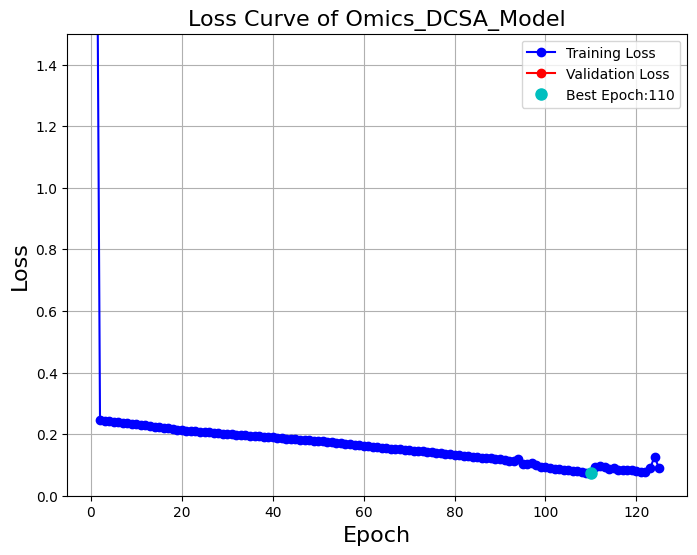

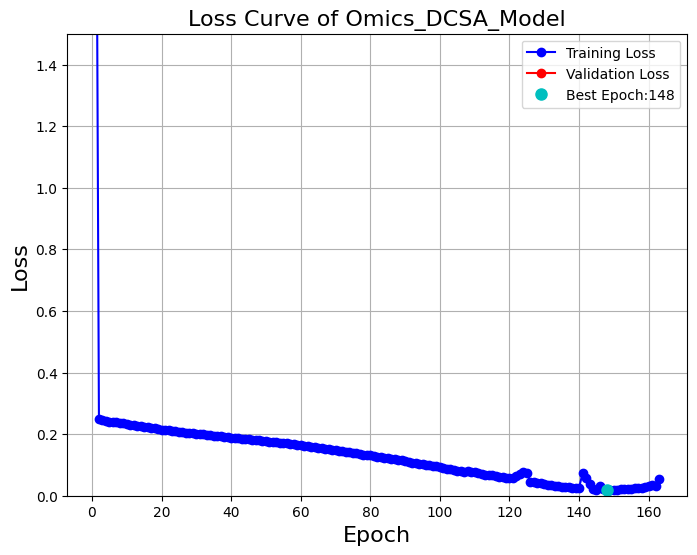

In [ ]:
%%time
from collections import defaultdict
unique_cancer_types = AUC_df['CancerType'].unique()
print(unique_cancer_types)
cancer_losses = defaultdict(dict)
cancer_metrics = defaultdict(dict)
# Loop through each cancer type
for cancer in unique_cancer_types:
    print(f"Testing on: {cancer}")
    
    # Split train/test
    train_df = AUC_df[AUC_df['CancerType'] != cancer]
    test_df = AUC_df[AUC_df['CancerType'] == cancer]

    set_seed(seed)
    def collate_fn(batch):
            gene_feature, drug_list, target = zip(*batch)
            return list(gene_feature), list(drug_list), list(target)
    test_dataset = InstanceResponseDataset(test_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn) #, num_workers=4, pin_memory=True
    train_dataset = InstanceResponseDataset(train_df, omics_data_dict, drug_df, drug_graph, include_omics, device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn) #, num_workers=4, pin_memory=True
    set_seed(seed)
    if model_name == "Omics_DrugESPF_Model":
        model = Omics_DrugESPF_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
    elif model_name == "Omics_DCSA_Model":
        model = Omics_DCSA_Model(omics_encode_dim_dict, drug_encode_dims, activation_func, activation_func_final, dense_layer_dim, device, ESPF, Drug_SelfAttention, pos_emb_type,
                            drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, max_drug_len,
                            n_layer,DA_Folder,TCGA_pretrain_weight_path_dict= TCGA_pretrain_weight_path_dict)
#     elif model_name == "GIN_DCSA_model":
#         model = GIN_DCSA_model(omics_encode_dim_dict, activation_func,activation_func_final,dense_layer_dim, device,
#                             drug_embedding_feature_size, intermediate_size, num_attention_heads , attention_probs_dropout_prob, hidden_dropout_prob, omics_numfeatures_dict, 
#                             n_layer,DA_Folder,TCGA_pretrain_weight_path_dict=TCGA_pretrain_weight_path_dict)
    model.to(device=device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)# Initialize optimizer
    
    (best_epoch, best_weight, BE_train_loss, 
     BEpo_trainLoss_W_penalty_ls, BEpo_trainLoss_WO_penalty_ls, 
     BE_train_targets , BE_train_outputs) = train( model, optimizer, 
                                               criterion, train_loader, device,
                                               ESPF, Drug_SelfAttention, seed ,
                                               weighted_threshold, few_weight, more_weight)
    print("best Epoch : ",best_epoch,"BE_train_loss : ",BE_train_loss)
    cancer = cancer.replace('/', '-')
    hyperparameter_folder_path = f"./results/LOcancer_{timestamp}_{criterion.loss_type}_train_loss{BE_train_loss:.7f}_BestTrainEpo{best_epoch}_file{response_file}_{hyperparameter_folder_part}_{''.join([f'{k}{v}' for k, v in omics_numfeatures_dict.items()])}_nlayer{n_layer}_DA-{DA_Folder}/{cancer}/" # /root/Winnie/PDAC
    os.makedirs(hyperparameter_folder_path, exist_ok=True)
    save_path = os.path.join(hyperparameter_folder_path, f'BestTrainWeight.pt')
    torch.save(best_weight, save_path)
    
    loss_curve(model_name, BEpo_trainLoss_WO_penalty_ls, [],
           best_epoch, BE_train_loss,hyperparameter_folder_path,
             loss_type="loss_WO_penalty")
    
    train_metrics, best_prob_threshold = metrics_calculator(torch.cat(BE_train_targets), torch.cat(BE_train_outputs), best_prob_threshold, metric, dataset="val")
    cancer_losses[cancer]['train'] = BE_train_loss
    cancer_metrics[cancer]['train'] = train_metrics
    
    # Load best weights and evaluate
    model.load_state_dict(best_weight)
    model.to(device=device)
    model.eval()
    
    (BE_test_targets,BE_test_outputs,
    test_loss_WO_penalty,test_outputs_before_final_activation_list) = evaluation (model, None,None, 
                                        criterion, test_loader, device, ESPF, Drug_SelfAttention,
                                        weighted_threshold, few_weight, more_weight, 
                                        outputcontrol='correlation')
    print("test_loss : ",test_loss_WO_penalty)
    test_metrics, _  = metrics_calculator(torch.cat(BE_test_targets), torch.cat(BE_test_outputs),best_prob_threshold, metric, dataset="test")
    cancer_losses[cancer]['test'] = test_loss_WO_penalty
    cancer_metrics[cancer]['test'] = test_metrics
    del model 
    # Set the current device
    torch.cuda.set_device("cuda:0")
    # Optionally, force garbage collection to release memory 
    gc.collect()
    # Empty PyTorch cache
    torch.cuda.empty_cache() # model 會從GPU消失，所以要evaluation時要重新load model

In [42]:
cancer_losses

defaultdict(dict,
            {'Ovarian Cancer': {'train': array(0.07391901, dtype=float32),
              'test': array(0.62773365, dtype=float32)},
             'Colon-Colorectal Cancer': {'train': array(0.01925664, dtype=float32),
              'test': array(1.2305495, dtype=float32)},
             'Skin Cancer': {'train': array(0.00043667, dtype=float32),
              'test': array(1.3948715, dtype=float32)},
             'Lung Cancer': {'train': array(0.00313299, dtype=float32),
              'test': array(1.6755177, dtype=float32)},
             'Bladder Cancer': {'train': array(0.00107046, dtype=float32),
              'test': array(1.8527377, dtype=float32)},
             'Breast Cancer': {'train': array(0.01797561, dtype=float32),
              'test': array(1.5064319, dtype=float32)},
             'Pancreatic Cancer': {'train': array(0.00098621, dtype=float32),
              'test': array(1.142652, dtype=float32)},
             'Brain Cancer': {'train': array(0.00082583, dty

In [12]:
best_prob_threshold

tensor(0.1023, device='cuda:0')

In [18]:
loss_dict = {
    'Ovarian Cancer': 0.62773365,
    'Colon-Colorectal Cancer': 1.2305495,
    'Skin Cancer': 1.3948715,
    'Lung Cancer': 1.6755177,
    'Bladder Cancer': 1.8527377,
    'Breast Cancer': 1.5064319
}

In [41]:
cancer_losses

defaultdict(dict,
            {'Ovarian Cancer': {'train': array(0.07391901, dtype=float32),
              'test': array(0.62773365, dtype=float32)},
             'Colon-Colorectal Cancer': {'train': array(0.01925664, dtype=float32),
              'test': array(1.2305495, dtype=float32)},
             'Skin Cancer': {'train': array(0.00043667, dtype=float32),
              'test': array(1.3948715, dtype=float32)},
             'Lung Cancer': {'train': array(0.00313299, dtype=float32),
              'test': array(1.6755177, dtype=float32)},
             'Bladder Cancer': {'train': array(0.00107046, dtype=float32),
              'test': array(1.8527377, dtype=float32)},
             'Breast Cancer': {'train': array(0.01797561, dtype=float32),
              'test': array(1.5064319, dtype=float32)},
             'Pancreatic Cancer': {'train': array(0.00098621, dtype=float32),
              'test': array(1.142652, dtype=float32)},
             'Brain Cancer': {'train': array(0.00082583, dty

In [54]:
 [float(cancer_losses[c.replace('/', '-')]['test']) for c in unique_cancer_types]

[0.6277336478233337,
 1.2305494546890259,
 1.394871473312378,
 1.6755176782608032,
 1.8527376651763916,
 1.5064319372177124,
 1.1426520347595215,
 2.752187728881836,
 2.9035792350769043,
 1.963706135749817,
 2.8978114128112793,
 1.2939614057540894,
 0.9744789004325867,
 1.2773648500442505,
 0.9742311239242554,
 2.5866591930389404,
 1.7216758728027344]

In [55]:
cancer_types = list(cancer_losses.keys())
cancer_types

['Ovarian Cancer',
 'Colon-Colorectal Cancer',
 'Skin Cancer',
 'Lung Cancer',
 'Bladder Cancer',
 'Breast Cancer',
 'Pancreatic Cancer',
 'Brain Cancer',
 'Kidney Cancer',
 'Gastric Cancer',
 'Sarcoma',
 'Thyroid Cancer',
 'Head and Neck Cancer',
 'Endometrial-Uterine Cancer',
 'Liver Cancer',
 'Esophageal Cancer',
 'Cervical Cancer',
 'test',
 'Colon/Colorectal Cancer']

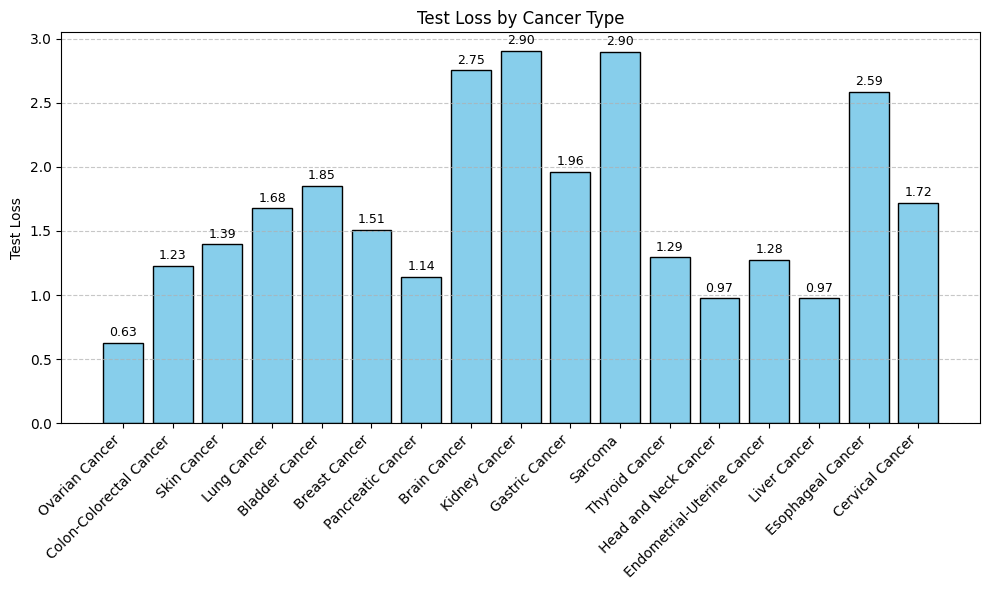

In [56]:
import matplotlib.pyplot as plt
# Extract keys and values
cancer_types = list(cancer_losses.keys())[:-2]
test_losses =  [float(cancer_losses[c.replace('/', '-')]['test']) for c in unique_cancer_types]
# Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(cancer_types, test_losses, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Test Loss')
plt.title('Test Loss by Cancer Type')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.03, f'{height:.2f}', ha='center', va='bottom', fontsize=9)
plt.show()
